# First start by building Lab 2a - Risk Tolerance Analysis.
1. This part analyzes risk tolerance using financial survey data from 2007 and 2009.
2. It computes risk-free and risky assets, adjusts for market changes, visualizes distributions, and calculates correlations between key variables.

# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
from pickle import dump
from sklearn.preprocessing import StandardScaler
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Load Dataset

In [2]:
# Define the file path using os.path.join for better compatibility across OS
DATA_PATH = os.path.join(os.getcwd(), "SCFP2009panel.csv")
# Load dataset into a Pandas DataFrame
dataset = pd.read_csv(DATA_PATH)

# Define Constants

In [3]:
# Define SP500 average values for respective years to adjust risk tolerance calculations
AVERAGE_SP500_2007 = 1478
AVERAGE_SP500_2009 = 948

# Compute Risk Tolerance (2007 & 2009)

In [4]:
# Calculate total risk-free and risky assets for 2007
dataset['RiskFree07'] = dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07']

# Compute risk tolerance for 2007
dataset['RT07'] = dataset['Risky07'] / (dataset['Risky07'] + dataset['RiskFree07'])

# Calculate total risk-free and risky assets for 2009
dataset['RiskFree09'] = dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09']

# Compute risk tolerance for 2009 with SP500 adjustment
dataset['RT09'] = (dataset['Risky09'] / (dataset['Risky09'] + dataset['RiskFree09'])) *(AVERAGE_SP500_2009 / AVERAGE_SP500_2007)

# Data Cleaning & Transformation

In [5]:
# Create a deep copy of dataset to preserve the original data
dataset2 = deepcopy(dataset)
# Calculate the absolute percentage change in risk tolerance between 2007 and 2009
dataset2['PercentageChange'] = np.abs(dataset2['RT09'] / dataset2['RT07'] - 1)
# Remove NaN and infinite values to ensure data integrity
dataset2.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset2.dropna(inplace=True)

# Plot Risk Tolerance Distributions

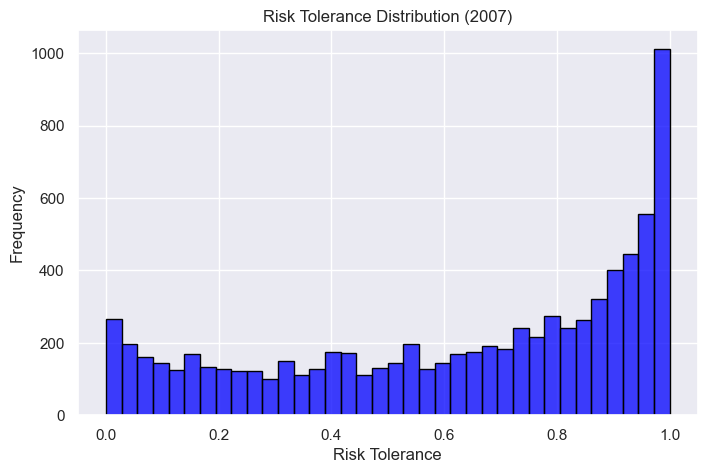

In [6]:
sns.set()
plt.figure(figsize=(8, 5))
# Plot distribution of risk tolerance for 2007
sns.histplot(dataset2['RT07'], bins=36, color='blue', edgecolor='black')
plt.title("Risk Tolerance Distribution (2007)")
plt.xlabel("Risk Tolerance")
plt.ylabel("Frequency")
plt.show()

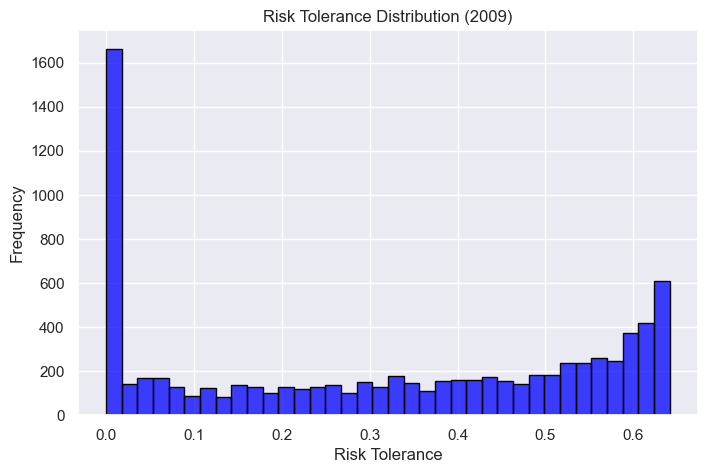

In [7]:
plt.figure(figsize=(8, 5))
# Plot distribution of risk tolerance for 2009
sns.histplot(dataset2['RT09'], bins=36, color='blue', edgecolor='black')
plt.title("Risk Tolerance Distribution (2009)")
plt.xlabel("Risk Tolerance")
plt.ylabel("Frequency")
plt.show()

# Filter Data - Remove Extreme Changes

In [8]:
# Create a deep copy of the cleaned dataset
dataset3 = deepcopy(dataset2)
# Remove records where the percentage change in risk tolerance exceeds 10%
dataset3 = dataset3[dataset3['PercentageChange'] <= 0.1]
# Compute the average risk tolerance between 2007 and 2009
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09']) / 2
# Drop unnecessary columns
dataset3.drop(columns=['RT07', 'RT09', 'PercentageChange'], inplace=True)

# Select Relevant Features

In [9]:
# Define the list of features to retain based on domain knowledge
selected_features = ['AGE07', 'EDCL07', 'MARRIED07', 'KIDS07', 'OCCAT107', 'INCOME07',
'RISK07', 'NETWORTH07', 'TrueRiskTolerance']
dataset3 = dataset3[selected_features]

# Correlation Matrix Visualization

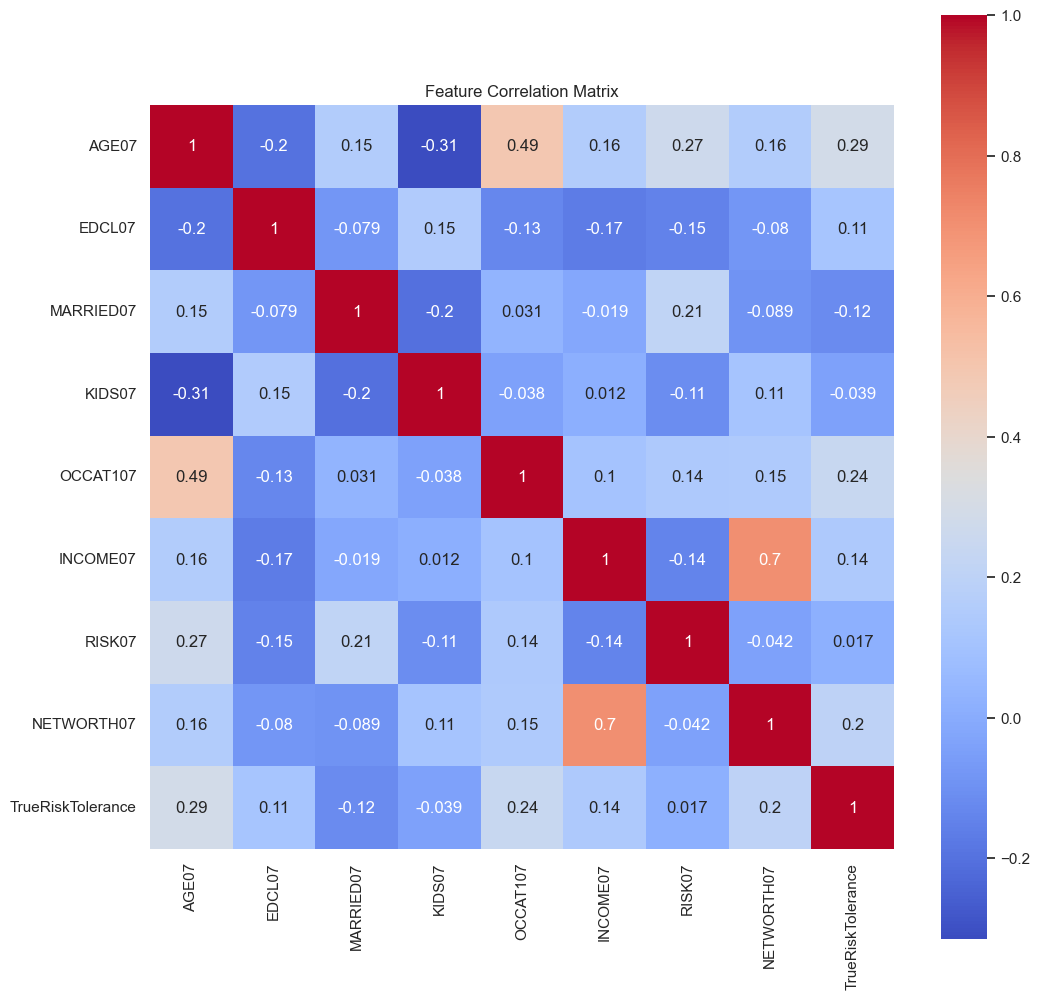

In [10]:
plt.figure(figsize=(12, 12))
# Generate heatmap to visualize correlations between selected features
sns.heatmap(dataset3.corr(), annot=True, cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Pairplot Visualization

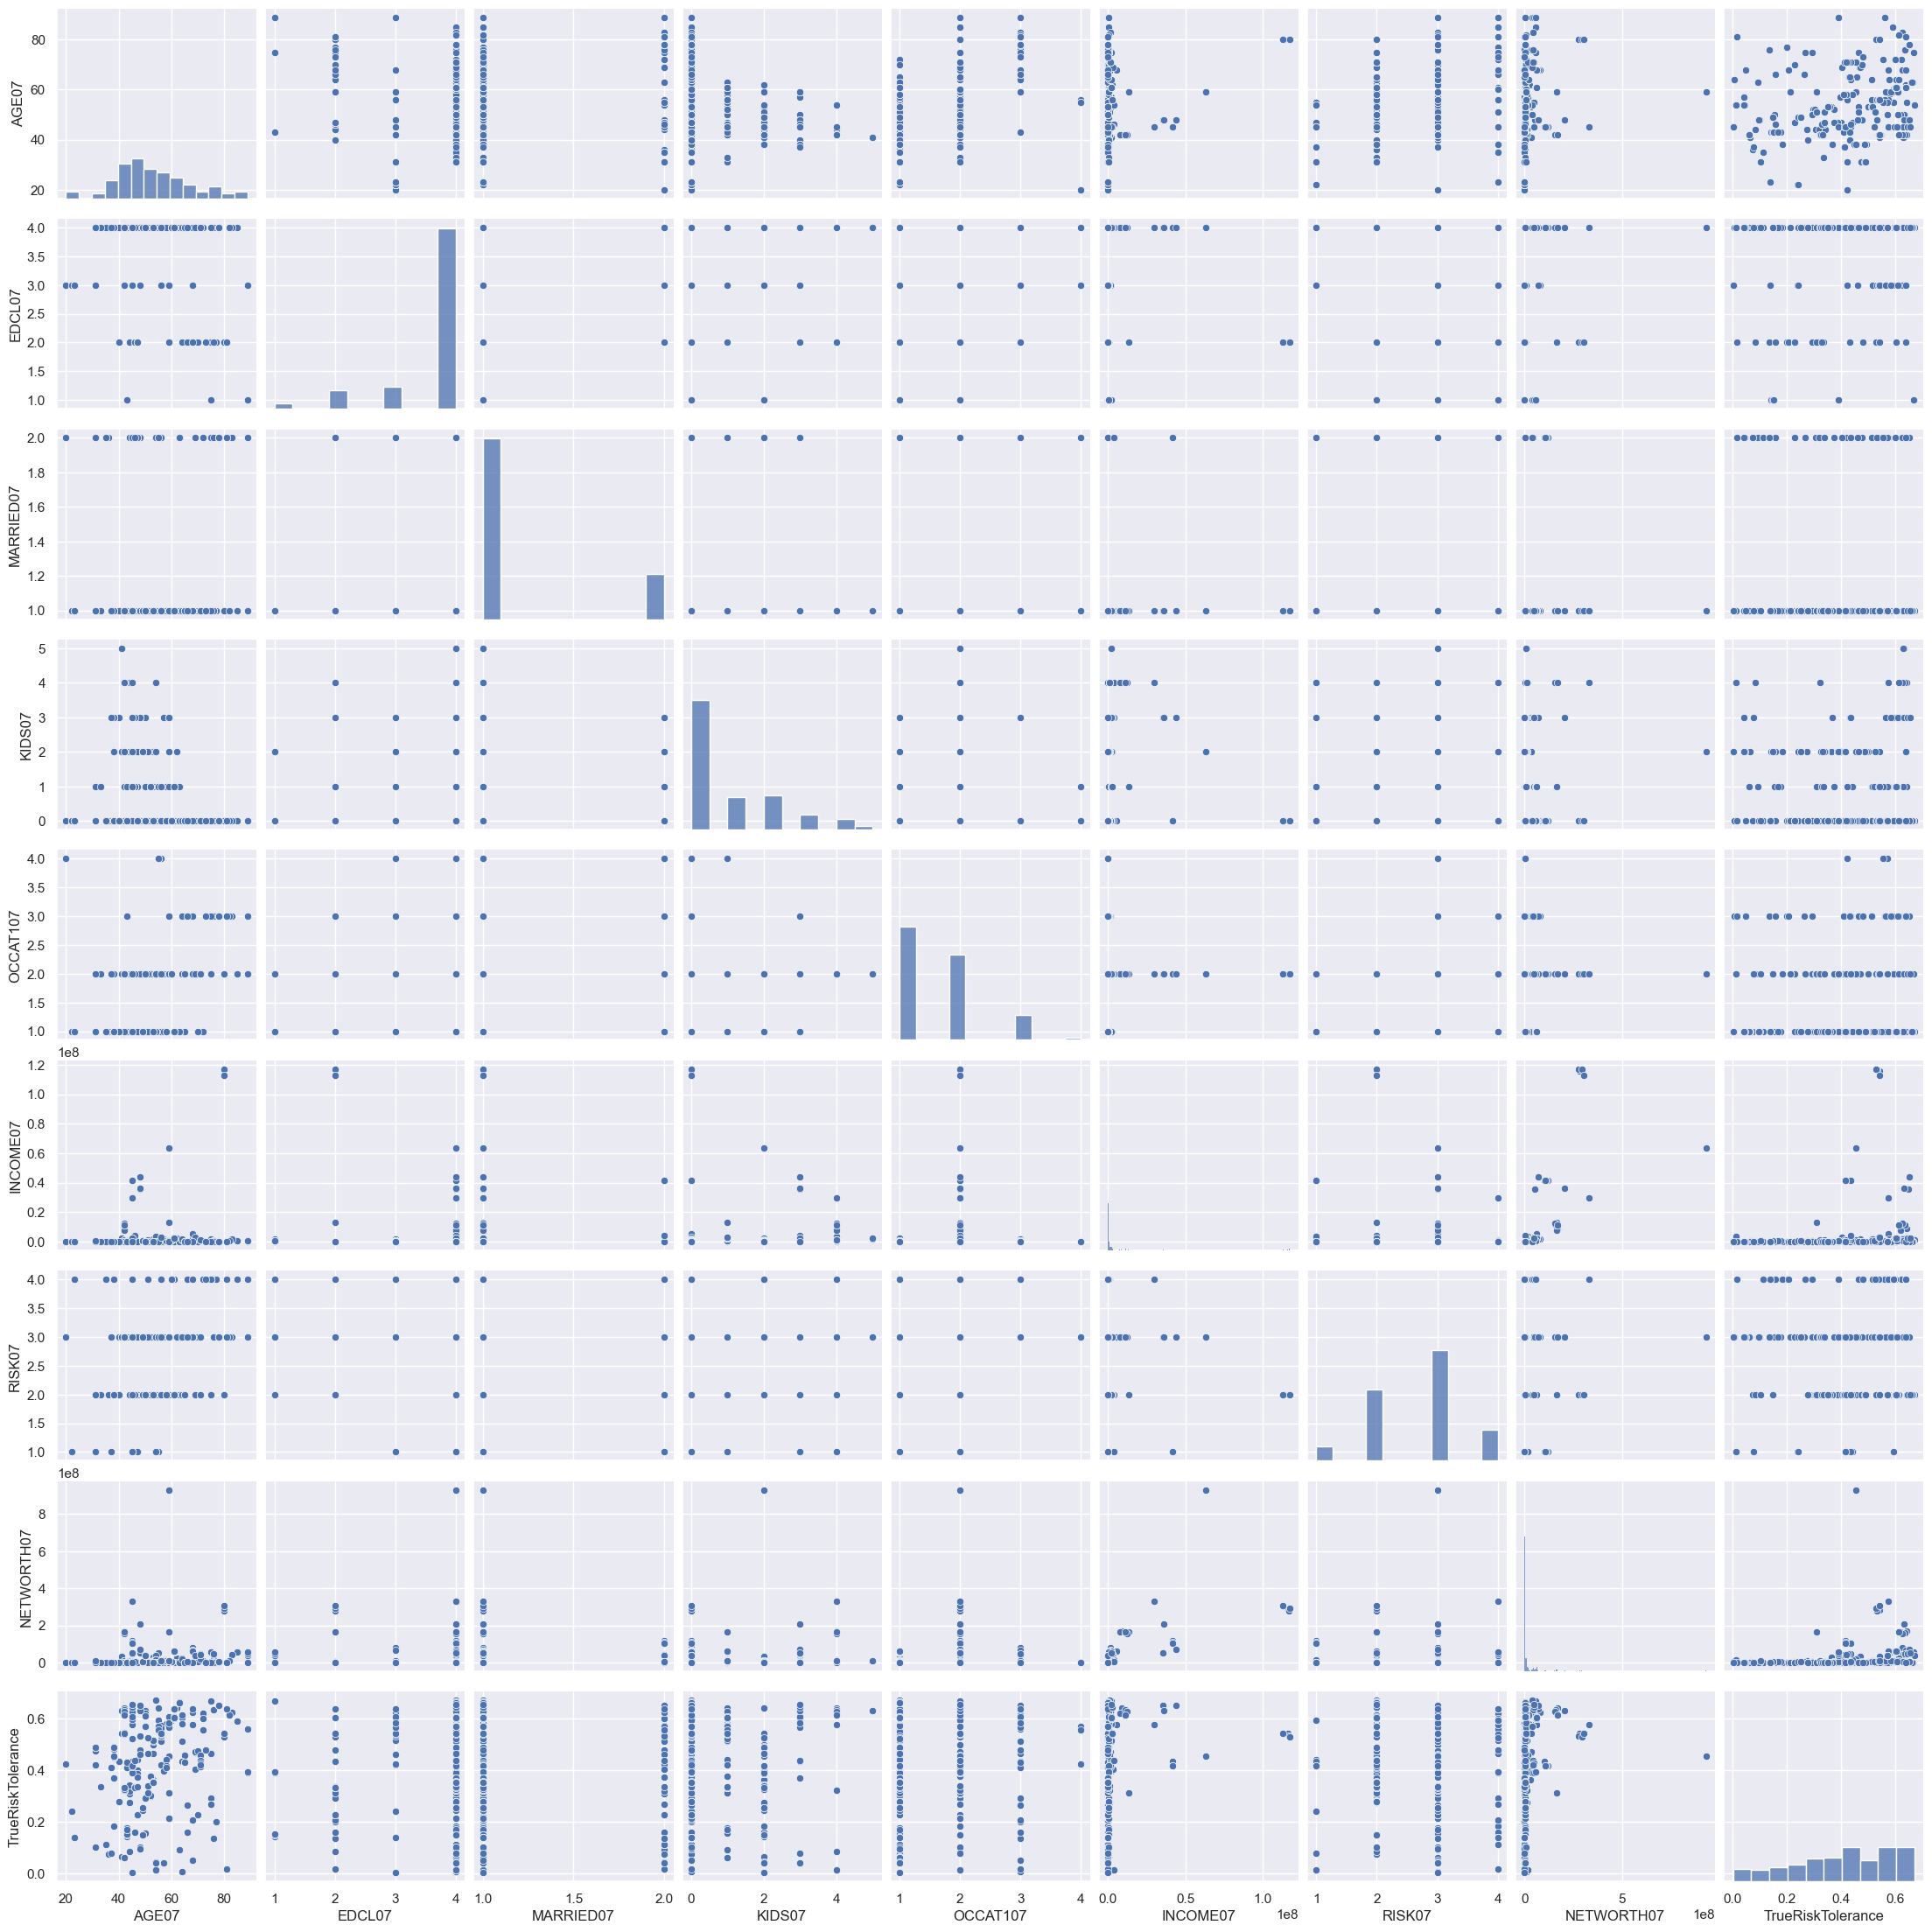

In [11]:
# Generate pairplots to analyze feature relationships visually
sns.pairplot(dataset3)
plt.show()

# Save Processed Dataset

In [12]:
# Save the cleaned and processed dataset for further use
output_file = 'build_lab2a_cleaned.sav'
dump(dataset3, open(output_file, 'wb'))
print("\n Build Lab 2a Processing Completed Successfully!\n")


 Build Lab 2a Processing Completed Successfully!



# Here, we continue to build lab2b

# import Required Libraries

In [13]:
# Import Required Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from copy import deepcopy
from pickle import dump, load

# Scikit-learn libraries for preprocessing, model training, and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

# TensorFlow/Keras for deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Split Data for Training and Validation

In [14]:
# Split dataset into training and validation sets
X = dataset3.drop(columns=['TrueRiskTolerance'])
Y = dataset3['TrueRiskTolerance']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, random_state=42)

# Model Selection

In [15]:
# Initialize models
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('SVR', SVR()),
    ('ABR', AdaBoostRegressor()),
    ('GBR', GradientBoostingRegressor()),
    ('RFR', RandomForestRegressor()),
    ('ETR', ExtraTreesRegressor())
]

In [16]:
# Evaluate models using cross-validation
num_folds = 10
scoring = 'r2'
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

LR: -0.3516 (1.3329)
LASSO: -0.6155 (1.8402)
EN: -0.5721 (1.8101)
KNN: 0.4352 (0.2263)
CART: 0.5577 (0.2830)
SVR: 0.1237 (0.1628)
ABR: 0.4462 (0.1622)
GBR: 0.6651 (0.1574)
RFR: 0.7197 (0.1485)
ETR: 0.7384 (0.1584)


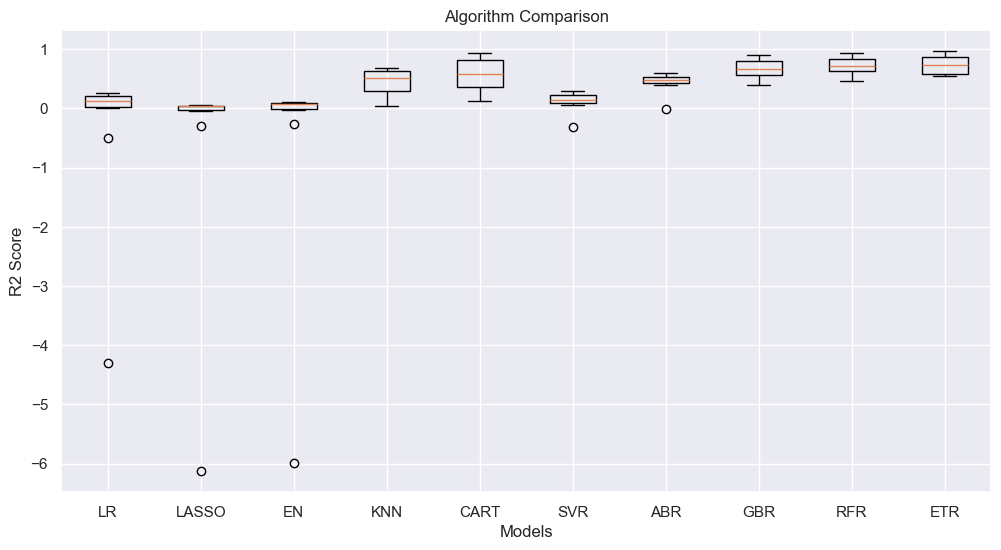

In [17]:
# Algorithm Comparison - draw box plot
plt.figure(figsize=(12, 6))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.xlabel('Models')
plt.ylabel('R2 Score')
plt.show()

* Based on the cross-validation results, Random Forest (RFR) appears to be the best model because it achieves the almost highest mean R² score (0.7197) among all tested models, with relatively low standard deviation (0.1485), which means it has more satble performance.

# Hyperparameter Tuning

In [18]:
# Perform a grid search to find the best number of estimators (n_estimators)
# Use KFold cross-validation and r2 scoring
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300]}
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='r2', cv=kfold)
grid_search.fit(X_train, Y_train)

# Retrieve and store the best n_estimators value
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'n_estimators': 250}


# Model Training and Final Evaluation

In [19]:
# Train best model (RandomForestRegressor) and evaluate
best_model = RandomForestRegressor(n_estimators=250, random_state=42)
best_model.fit(X_train, Y_train)
predictions = best_model.predict(X_validation)
print(f"R2 Score on Validation Set: {r2_score(Y_validation, predictions):.4f}")
print(f"Mean Squared Error (MSE) on Validation Set: {mean_squared_error(Y_validation, predictions):.4f}")

R2 Score on Validation Set: 0.6172
Mean Squared Error (MSE) on Validation Set: 0.0118


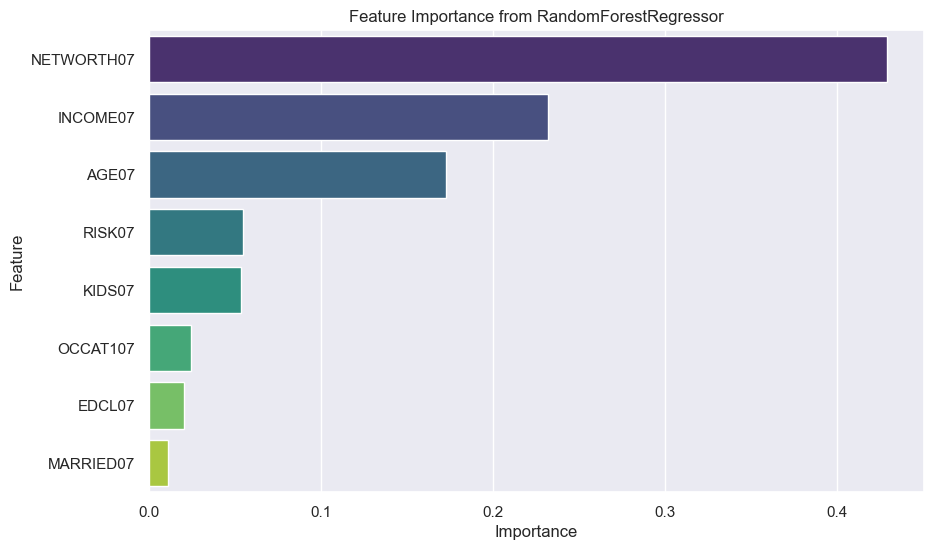

In [20]:
# Feature Importance Analysis
feature_importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Model Saving and Deployment

In [21]:
# Save trained model
output_file = 'build_lab2b.sav'
dump(best_model, open(output_file, 'wb'))
print("\nBuild Lab 2b Processing Completed Successfully!\n")


Build Lab 2b Processing Completed Successfully!



In [22]:
# Load the Model for Future Predictions
loaded_model = load(open(output_file, 'rb'))

# Make predictions on X_validation
loaded_predictions = loaded_model.predict(X_validation)

# Compute and display final performance metrics
final_mse = mean_squared_error(Y_validation, loaded_predictions)
final_r2 = r2_score(Y_validation, loaded_predictions)

print(f"Final Mean Squared Error (MSE) on Validation Set: {final_mse:.4f}")
print(f"Final R2 Score on Validation Set: {final_r2:.4f}")

Final Mean Squared Error (MSE) on Validation Set: 0.0118
Final R2 Score on Validation Set: 0.6172


* This is for reproducibility check: We can see reloaded model performs identically to the original.